# Data Scientist :: Code challenge

For this challenge, you will do credit line modelling using the bank statements of the
company XYZ GmbH to respond to the following questions:
1. Identify, plot and describe the financial development of XYZ GmbH .
2. What amount of line would you give to XYZ GmbH in each month, assuming that we
give each customer a credit line of 30% of its estimated total costs for the upcoming
month.
3. Given a monthly credit line of 30% of total cash outflow (we use the past months as a
predictor for the following months; you can assume we calculate the line on the first
of the month), determine
a. In which months will company XYZ GmbH starts having problems to meet its
debt obligations being too risky to continue having a monthly credit line.
b. In which months will the company be able to meet its obligations normally
again without a high risk.

# Assumptions:
● The credit line is calculated on the 1st of the month for the following month.
● The credit limit is based on the company's cash outflows (all outgoing transactions).

# What is a statement of account?
A statement of account is issued by a business to its customers. It shows all sales made to a customer over a given period. They are issued to customers to prompt them to pay a balance which will soon be due for payment or to remind them to pay an overdue balance.

They are also useful for the customer, not only to remind them to make the payment, but also to allow them to cross reference the invoices and credit notes with those on their own system. It could be that they have not received all the invoices on the statement, in which case they can request copies from the business to ensure that their own records will be accurate.

# 1. Identify, plot and describe the financial development of XYZ GmbH

>>Loading the dataset, importing libraries and cleaning the datset

In [628]:
import pandas as pd 
import matplotlib as style
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas_datareader as pdr
import datetime
import chart_studio.plotly
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [629]:
# Raw data cleaned to be used into the solution
# delimited using ; and , were removed to avoid an additional issue of whitespace

mydateparser = lambda x: pd.datetime.strptime(x, "%d.%m.%y")
df= pd.read_csv('XYZ_GmbH_bankstatements.csv', delimiter = ";" , encoding = "iso-8859-1",
                parse_dates = ['date_start_balance','date_end_balance','booking_date'],
                index_col= 0 ,date_parser = mydateparser)
df1 = df.replace(',','', regex = True)
df1.head()

date_start_balance date_end_balance booking_date start_balance end_balance  \
1         2016-02-22       2016-03-22   2016-03-22       3590838     3589838   
2         2016-02-22       2016-03-22   2016-03-22         69788       68788   
3         2016-03-15       2016-03-21   2016-03-21        452165       46201   
4         2016-03-15       2016-03-21   2016-03-21        452165       46201   
5         2016-03-17       2016-03-22   2016-03-22        306161      306061   

  amount     booking_text  tx_code  
1    -10        GEBUEHREN      808  
2    -10        GEBUEHREN      808  
3    520  SEPA-Gutschrift      166  
4   4645  SEPA-Gutschrift      166  
5    -10        GEBUEHREN      808

In [630]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30643 entries, 1 to 30643
Data columns (total 8 columns):
date_start_balance    30643 non-null datetime64[ns]
date_end_balance      30643 non-null datetime64[ns]
booking_date          30643 non-null datetime64[ns]
start_balance         30643 non-null object
end_balance           30643 non-null object
amount                30643 non-null object
booking_text          30469 non-null object
tx_code               30523 non-null float64
dtypes: datetime64[ns](3), float64(1), object(4)
memory usage: 2.1+ MB


In [631]:
df1.shape

(30643, 8)

# Missing Value Check and further data prep

In [632]:
# import pandas as pd
# from datetime import datetime
# from calendar import monthrange
# dates = df1['date_start_balance'].tolist()
# dates_transform = []
# for i in range(0,len(dates)):
#     dates_transform.append(datetime.strptime(dates[i], "%d.%m.%y"))
# missingbegin = []
# missingend = []
# for i in range(0,len(dates_transform)-1):
#     if dates_transform[i+1].month - dates_transform[i+1].month != 1:
#         for j in range(dates_transform[i].month+1,dates_transform[i+1].month):
#             missingbegin.append(datetime(dates_transform[i].year, j,1))
#             missingend.append(datetime(dates_transform[i].year, j, monthrange(dates_transform[i].year, j)[-1]))
# newdf = pd.DataFrame({'date_start_balance':missingbegin,'date_end_balance':missingend})
# newdf['start_balance'] = 0
# df1 = df1.append(newdf)
# df1['date_start_balance'] = pd.to_datetime(df1['date_start_balance'])
# df1['date_end_balance'] = pd.to_datetime(df1['date_end_balance'])
# print(df1.info())
# print(df1.head(10))

In [633]:
s = df1.set_index('booking_date').resample('MS').size()
s[s == 0].index.tolist()
print(s)

booking_date
2016-03-01     691
2016-04-01    2157
2016-05-01    1492
2016-06-01    2863
2016-07-01    2580
2016-08-01    1686
2016-09-01    1396
2016-10-01    2898
2016-11-01    1838
2016-12-01    1640
2017-01-01    4753
2017-02-01    3170
2017-03-01    2256
2017-04-01     921
2017-05-01     298
2017-06-01       0
2017-07-01       4
Freq: MS, dtype: int64


As we can see from above there is no data available for the month of June 2017

In [634]:
df1['month'] = df1['booking_date'].apply(lambda x: datetime.datetime.strftime(x, "%B-%Y"))
distinct_month = df1.month.unique()
distinct_month

array(['March-2016', 'April-2016', 'May-2016', 'June-2016', 'July-2016',
       'August-2016', 'September-2016', 'October-2016', 'November-2016',
       'December-2016', 'January-2017', 'April-2017', 'February-2017',
       'March-2017', 'July-2017', 'May-2017'], dtype=object)

>As we can see from above there is no data available for the month of June 2017 which will be treated as missing values as it is coming in bw the series of the data. In financial data , we cannot break the continuity of the data frame

>Also our job is to treat the missing values basis a balance amount for the month of June so that we have a standard data set
>To impute the missing value for June 2017 @
        I will add three date values, start , end and booking date as standard value 
        The booking date will be equal to the end balance date as this is the case with the entire dataset except 4 obs
        

In [635]:
# df1.reindex(pd.period_range(df1.booking_date.min(), df1.booking_date.max(), freq= 'M')).isnull().all(1)

In [636]:
df1= pd.DataFrame(np.array([['2017-06-01 00:00:00' ,'2017-06-30 00:00:00', '2017-06-30 00:00:00', 'June-2017']]), columns=['date_start_balance', 'date_end_balance', 'booking_date','month']).append(df1, ignore_index=True)

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [637]:
df1.head()

amount         booking_date     booking_text     date_end_balance  \
0    NaN  2017-06-30 00:00:00              NaN  2017-06-30 00:00:00   
1    -10  2016-03-22 00:00:00        GEBUEHREN  2016-03-22 00:00:00   
2    -10  2016-03-22 00:00:00        GEBUEHREN  2016-03-22 00:00:00   
3    520  2016-03-21 00:00:00  SEPA-Gutschrift  2016-03-21 00:00:00   
4   4645  2016-03-21 00:00:00  SEPA-Gutschrift  2016-03-21 00:00:00   

    date_start_balance end_balance       month start_balance  tx_code  
0  2017-06-01 00:00:00         NaN   June-2017           NaN      nan  
1  2016-02-22 00:00:00     3589838  March-2016       3590838      808  
2  2016-02-22 00:00:00       68788  March-2016         69788      808  
3  2016-03-15 00:00:00       46201  March-2016        452165      166  
4  2016-03-15 00:00:00       46201  March-2016        452165      166

In [638]:
df1['date_start_balance'] = df1['date_start_balance'].astype('datetime64[ns]')
df1['date_end_balance'] = df1['date_end_balance'].astype('datetime64[ns]')
df1['booking_date'] = pd.to_datetime(df1['booking_date'])
df1['amount'] = df1['amount'].astype(float)
df1['start_balance'] = df1['start_balance'].astype(float)
df1['end_balance'] = df1['end_balance'].astype(float)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30644 entries, 0 to 30643
Data columns (total 9 columns):
amount                30643 non-null float64
booking_date          30644 non-null datetime64[ns]
booking_text          30469 non-null object
date_end_balance      30644 non-null datetime64[ns]
date_start_balance    30644 non-null datetime64[ns]
end_balance           30643 non-null float64
month                 30644 non-null object
start_balance         30643 non-null float64
tx_code               30523 non-null float64
dtypes: datetime64[ns](3), float64(4), object(2)
memory usage: 2.1+ MB


In [639]:
#Looking for missing data and then handling it accordingly
def find_missing(data):
    # number of missing values
    count_missing = df1.isnull().sum().values
    # total records
    total = df1.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
find_missing(df1).head(10)

missing_count  missing_ratio
amount                          1              0
booking_date                    0              0
booking_text                  175              0
date_end_balance                0              0
date_start_balance              0              0
end_balance                     1              0
month                           0              0
start_balance                   1              0
tx_code                       121              0

Now as we can see that we have to impute amount, booking text and teansaction code

In [640]:
#imputing the most recurring text description and txn code in the missing data placeholders
# mode will be a good option as for the categorical variable - booking_text it makes sense to impute the max recurring variable
# mode will also be a good option for tx_code as well as this is not a proper continous variable that we can use, so there is not point of imputing this with the mean or median
df1['amount'].fillna((df1['amount'].mean()), inplace=True)
df1['start_balance'].fillna((df1['start_balance'].mean()), inplace=True)
df1['end_balance'].fillna((df1['end_balance'].mean()), inplace=True)
df1 = df1.fillna(df1.mode().iloc[0])
df1.head()

amount booking_date     booking_text date_end_balance date_start_balance  \
0  -60790   2017-06-30  SEPA-Gutschrift       2017-06-30         2017-06-01   
1     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
2     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
3     520   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   
4    4645   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   

   end_balance       month  start_balance  tx_code  
0     26931793   June-2017       26524408      166  
1      3589838  March-2016        3590838      808  
2        68788  March-2016          69788      808  
3        46201  March-2016         452165      166  
4        46201  March-2016         452165      166

In [641]:
df1['amount'] = df1['amount'].astype('int64')
df1['start_balance'] = df1['start_balance'].astype('int64')
df1['end_balance'] = df1['end_balance'].astype('int64')
df1.head()

amount booking_date     booking_text date_end_balance date_start_balance  \
0  -60790   2017-06-30  SEPA-Gutschrift       2017-06-30         2017-06-01   
1     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
2     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
3     520   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   
4    4645   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   

   end_balance       month  start_balance  tx_code  
0     26931792   June-2017       26524408      166  
1      3589838  March-2016        3590838      808  
2        68788  March-2016          69788      808  
3        46201  March-2016         452165      166  
4        46201  March-2016         452165      166

In [642]:
#Looking for missing data and then handling it accordingly
def find_missing(data):
    # number of missing values
    count_missing = df1.isnull().sum().values
    # total records
    total = df1.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
find_missing(df1).head(12)

missing_count  missing_ratio
amount                          0              0
booking_date                    0              0
booking_text                    0              0
date_end_balance                0              0
date_start_balance              0              0
end_balance                     0              0
month                           0              0
start_balance                   0              0
tx_code                         0              0

In [643]:
# Statistical Summary
print("Summary of the total booked amount:\n")
df1['amount'].describe().apply(lambda x: format(x, 'f'))

Summary of the total booked amount:



count        30644.000000
mean        -60790.332072
std        3750066.935644
min      -53025695.000000
25%          -1884.000000
50%            500.000000
75%          13889.750000
max      299829231.000000
Name: amount, dtype: object

In [644]:
# Lets check now if the bookings were made always on the ending balance date or not

In [645]:
df1['date_end_balance'].equals(df1['booking_date'])

False

In [646]:
# as this has returned false we need to check which all values are not matching
df1.loc[~(df1['date_end_balance'] == df1['booking_date'])]

amount booking_date     booking_text date_end_balance  \
29617     21000   2017-07-26  SEPA-Gutschrift       2017-04-05   
29618    558842   2017-07-26  SEPA-Gutschrift       2017-04-05   
29619       -17   2017-07-26  SEPA-Gutschrift       2017-04-05   
29620  26886391   2017-07-26  SEPA-Gutschrift       2017-04-05   

      date_start_balance  end_balance      month  start_balance  tx_code  
29617         2017-04-03    108872734  July-2017       84935819       25  
29618         2017-04-03    108872734  July-2017       84935819       25  
29619         2017-04-03    108872734  July-2017       84935819       25  
29620         2017-04-03    108872734  July-2017       84935819       25

In [647]:
# Also lets chcek if there are any instances where the end date of balance is smaller than the start date which should ideally not happen
a = np.where(df1['date_end_balance'] > df1['date_start_balance'],1,0)
print(a)

[1 1 1 ... 1 1 1]


### Let me  add some more features to the dataset that will help in further exploration

In [648]:
# Adding Quarter feature to see data better
lst = [df1]
for column in lst:
    column.loc[(column["booking_date"] >= '2016-01-01') & (column["booking_date"] <= '2016-03-31'), "Quarter"] = 'Q1-2016'
    column.loc[(column["booking_date"] >= '2016-04-01') & (column["booking_date"] <= '2016-06-30'), "Quarter"] = 'Q2-2016'
    column.loc[(column["booking_date"] >= '2016-07-01') & (column["booking_date"] <= '2016-09-30'), "Quarter"] = 'Q3-2016'
    column.loc[(column["booking_date"] >= '2016-10-01') & (column["booking_date"] <= '2016-12-31'), "Quarter"] = 'Q4-2016'
    column.loc[(column["booking_date"] >= '2017-01-01') & (column["booking_date"] <= '2017-03-31'), "Quarter"] = 'Q1-2017'
    column.loc[(column["booking_date"] >= '2017-04-01') & (column["booking_date"] <= '2017-06-30'), "Quarter"] = 'Q2-2017'
    column.loc[(column["booking_date"] >= '2017-07-01') & (column["booking_date"] <= '2017-09-30'), "Quarter"] = 'Q3-2017'
    column.loc[(column["booking_date"] >= '2017-10-01') & (column["booking_date"] <= '2017-12-31'), "Quarter"] = 'Q4-2017'
    df1['Quarter'] = pd.Categorical(df1['Quarter'], ["Q1-2016","Q2-2016","Q3-2016","Q4-2016","Q1-2017","Q2-2017","Q3-2017"])

In [649]:
# Let me also add a debit/credit feature col
df1['debit_credit'] = np.where(df1['amount']>=1, 'Credit', 'Debit')

In [650]:
#Creating seperate features for debit and credit values for better analysis
#Also I have used abs function to return the +ve value for debit col
df1['debit'] = np.where(df1['debit_credit']== "Debit", abs(df1.amount),0)
df1['credit'] = np.where(df1['debit_credit']== "Credit", df1.amount,0)

In [651]:
# Lets check the features that I have created as of now
df1.head()

amount booking_date     booking_text date_end_balance date_start_balance  \
0  -60790   2017-06-30  SEPA-Gutschrift       2017-06-30         2017-06-01   
1     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
2     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
3     520   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   
4    4645   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   

   end_balance       month  start_balance  tx_code  Quarter debit_credit  \
0     26931792   June-2017       26524408      166  Q2-2017        Debit   
1      3589838  March-2016        3590838      808  Q1-2016        Debit   
2        68788  March-2016          69788      808  Q1-2016        Debit   
3        46201  March-2016         452165      166  Q1-2016       Credit   
4        46201  March-2016         452165      166  Q1-2016       Credit   

   debit  credit  
0  60790       0  
1     10       0  
2     10       0  
3      0     520  
4      0    4645

In [652]:
# Let me create some categories of different bookings_text that we have received.
#These categories will be then analysed according to the debit and credit columns that I have created above
#to better understand the company's position

# Cols for categories pertaining to credit
lst = [df1]
for column in lst:
    column.loc[(column["booking_text"].isin(['SEPA-Gutschrift','SEPA-Cash Management Gutsch','FASTER PAYMENTS',
                                            'SCHECK-EV','BACS CREDIT','POS Gutschrift','Scheckeinreichung e.V.','EINZAHLUNG','GUTSCHRIFT','SEPA-Dauerauftrag','EUELEKTR.'])) & (column["debit_credit"] == 'Credit'), 'financial_category'] = 'Reveunue_credit'
    column.loc[(column["booking_text"].isin(['SEPA-Regierungsgutschrift'])) & (column["debit_credit"] == 'Credit'), 'financial_category'] = 'Tax_Refund_credit'
    column.loc[(column["booking_text"].isin(['SEPA Rueckgabe','SEPA Reject','SEPA-Dauerauftrag','SEPA-Gehaltsgutschrift','STORNO','SEPA Lastschrift-Rueckgabe'])) & (column["debit_credit"] == 'Credit'), 'financial_category'] = 'Returns_credit'
    column.loc[(column["booking_text"].isin(['INTERNAL TRANSFER'])) & (column["debit_credit"] == 'Credit'), 'financial_category'] = 'Inter_Company_Credit'
    column.loc[(column["booking_text"].isin(['SEPA-Aussenhandel','AUSSENH.'])) & (column["debit_credit"] == 'Credit'), 'financial_category'] = 'Foreign_Receipt_Credit'
# Cols for categories pertaining to debit
    column.loc[(column["booking_text"].isin(['GEBUEHREN','FIXED ACCOUNT CHARGE','CHARGE','MISC CHARGES','BELASTUNG'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Bank_charges_debit'
    column.loc[(column["booking_text"].isin(['EUELEKTR.','Kreditkartenabrechnung','SEPA Basislastschrift','SEPA-Ueberweisung','Eilzahlung','FASTER PAYMENTS','SEPA-Aussenhandel','AUSZAHLUNG','STANDING ORDER','FUNDS TRANSFER DR','BELASTUNG','SEPA-Firmenlastschrift','SEPA manuelle Ueberweisung','Eilueberweisung','SEPA-Gutschrift','GUTSCHRIFT','AUSLSCHECK'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Payments_made_debit'
    column.loc[(column["booking_text"].isin(['AUSSENH.'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Foreign_payments_debit'
    column.loc[(column["booking_text"].isin(['SEPA-Ueberweisungsdatei'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Salary_payouts_debit'
    column.loc[(column["booking_text"].isin(['SEPA Rueckgabe','STORNO'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Returns_debit'
    column.loc[(column["booking_text"].isin(['ABSCHLUSS','DEALING','PROVISION'])) & (column["debit_credit"] == 'Debit'), 'financial_category'] = 'Returns_debit'
    

In [653]:
continuous_vars = df1.describe().columns
categorical_vars = df1.describe(include=["object"]).columns
print(continuous_vars)
print(categorical_vars)

Index(['amount', 'end_balance', 'start_balance', 'tx_code', 'debit', 'credit'], dtype='object')
Index(['booking_text', 'month', 'debit_credit', 'financial_category'], dtype='object')


### Below let me start with some useful plots that will help in understanding the financial position of the company xyz gmbh better

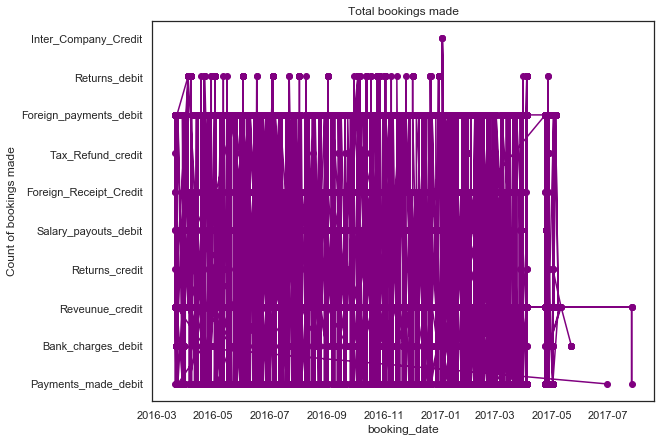

In [654]:
from matplotlib.dates import DateFormatter
fig, ax2 = plt.subplots(figsize=(9, 7))

# Add the x-axis and the y-axis to the plot
ax2.plot(df1['booking_date'],
        df1['financial_category'], '-o',
        color='purple')

# Set title and labels for axes
ax2.set(xlabel="booking_date",
       ylabel="Count of bookings made",
       title="Total bookings made")
plt.show()

**Clearly we can see that this is not a good view to have. Lets now drill a little bit further and see how these transactions are behaving

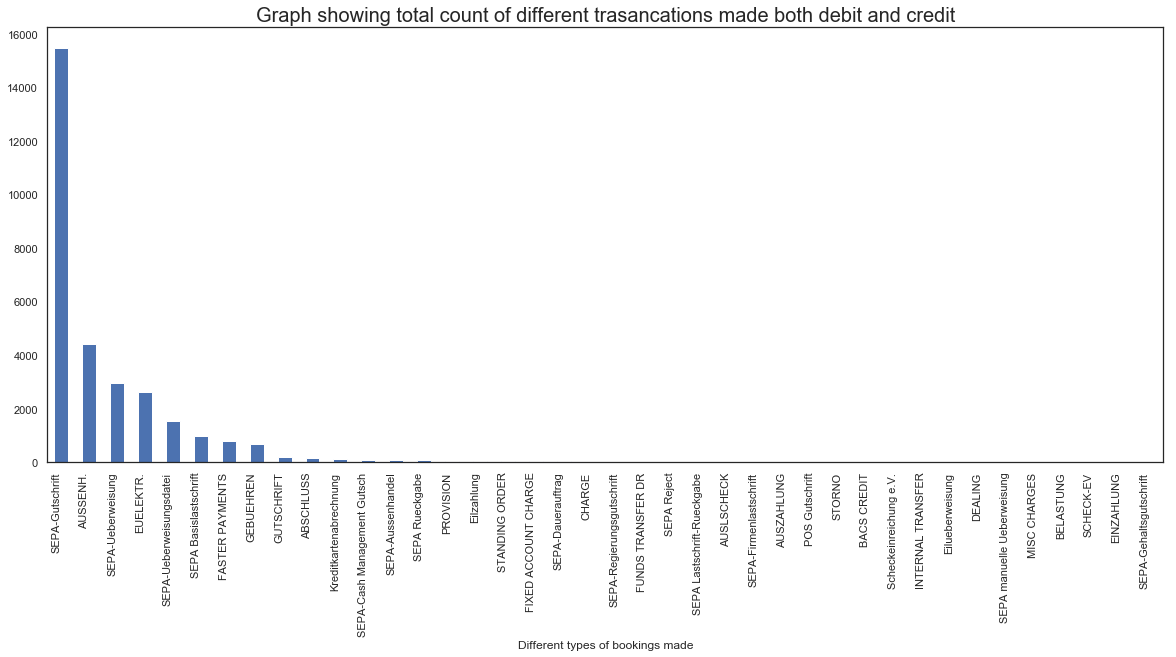

In [655]:
# let us  see how many transactions have occured on every booking text that we have got with the help of a count plot
sns.set(style="white")
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# sns.countplot(x='booking_text'.value_counts().index, data=df1,palette="Set1")
df['booking_text'].value_counts().plot(kind="bar")
ax.set_title("Graph showing total count of different trasancations made both debit and credit", fontsize=20)
ax.set_xlabel("Different types of bookings made")
plt.show()

##### Clearly we can see that the top 5 booking texts in terms of recurrance months over months are:
SEPA-Gutschrift
AUSSENH.
SEPA-Ueberweisung
EUELEKTR.
SEPA-Ueberweisungsdatei
SEPA Basislastschrift
We will see later as to how much impact do these transactions have in terms of the amount value

In [656]:
# Lets now see an overview of all debit and credit transactions over a period of two years as per the data
#As the data is distributed across two years, it is very difficult to plot clearly such huge transactions, hence range slider would be a good choice
import plotly.offline as pyo
from plotly import graph_objs as go
pyo.init_notebook_mode()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df1.booking_date, y=df1['credit'], name="credit",
                         line_color='purple'))

fig.add_trace(go.Scatter(x=df1.booking_date, y=df1['debit'], name="debit",
                         line_color='orange'))

fig.layout.update(title_text='Plot showing debit and credit transactions over a period of two years',paper_bgcolor='rgb(233,233,233)',
                  xaxis_rangeslider_visible=True)
fig.show()

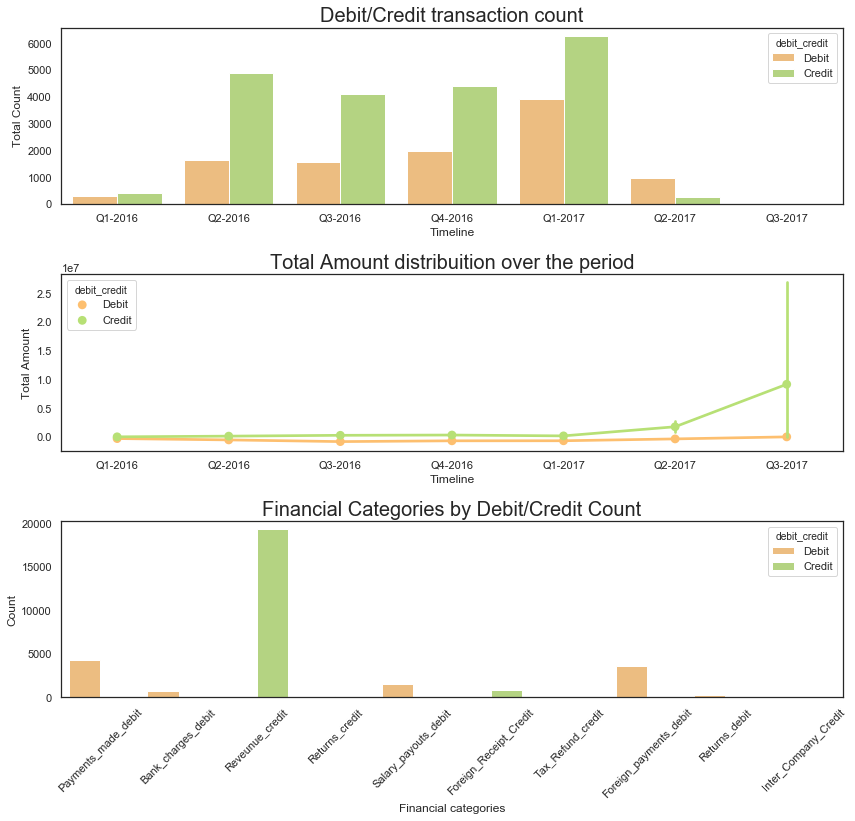

In [657]:
# Lets now see some distribution of debit.credit at quarter level to understand the trends 
plt.figure(figsize = (14,12))

g= plt.subplot(311)
g = sns.countplot(x="Quarter", data=df1, 
              palette="RdYlGn",  hue = "debit_credit")
g.set_xlabel("Timeline", fontsize=12)
g.set_ylabel("Total Count", fontsize=12)
g.set_title("Debit/Credit transaction count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Quarter", y ="amount",data=df1,
                   hue="debit_credit", palette="RdYlGn")
g1.set_xlabel("Timeline", fontsize=12)
g1.set_ylabel("Total Amount", fontsize=12)
g1.set_title("Total Amount distribuition over the period", fontsize=20)

plt.subplot(313)
g3 = sns.countplot(x="financial_category", data=df1, 
              palette="RdYlGn", hue = "debit_credit")
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)
g3.set_xlabel("Financial categories", fontsize=12)
g3.set_ylabel("Count", fontsize=12)
g3.set_title("Financial Categories by Debit/Credit Count", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)
plt.show()

In [658]:
print("Values describe: ")
print(pd.crosstab(df1.financial_category, df1.debit_credit))

Values describe: 
debit_credit            Credit  Debit
financial_category                   
Bank_charges_debit           0    753
Foreign_Receipt_Credit     845      0
Foreign_payments_debit       0   3605
Inter_Company_Credit         3      0
Payments_made_debit          0   4254
Returns_credit             125      0
Returns_debit                0    233
Reveunue_credit          19284      0
Salary_payouts_debit         0   1519
Tax_Refund_credit           23      0


Some obervations :
    Revenue credit has the maximum number of  booking transactions happening 
    There are some categories with some very less transactions like Inter company credit or bank charges or Tax refund credit
    
    

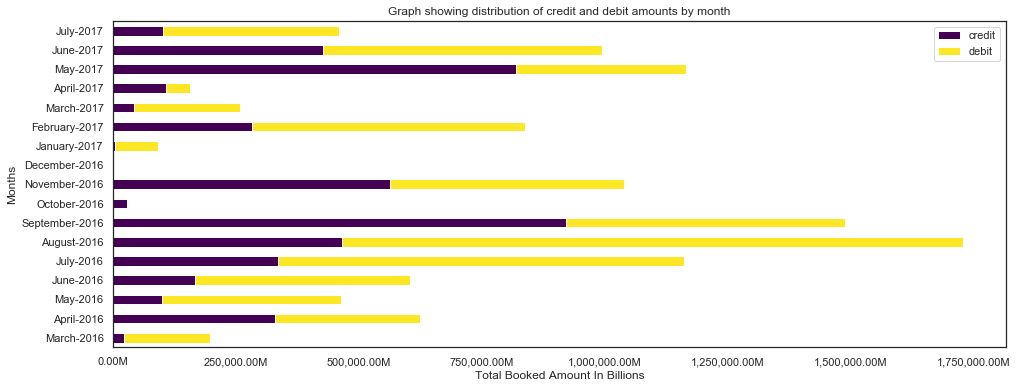

In [659]:
## lets now plot a simple pivot to understand impact of debit and credit and see at both quarter and monthly level 
table1 = pd.pivot_table(df1, values=['credit', 'debit'], index=['month'],
                     aggfunc={'credit': np.sum,
                              'debit':  np.sum})
ax=table1.plot(kind='barh', stacked=True, figsize=[16,6], colormap='viridis')
ax.set_title("Graph showing distribution of credit and debit amounts by month")
ax.set_xlabel("Total Booked Amount In Billions",fontsize=12)
ax.set_ylabel("Months",fontsize=12)
ax.set_yticklabels(('March-2016', 'April-2016', 'May-2016', 'June-2016', 'July-2016','August-2016','September-2016','October-2016',
                   'November-2016','December-2016','January-2017','February-2017','March-2017', 'April-2017', 'May-2017', 'June-2017', 'July-2017'))
plt.ticklabel_format(style='plain', axis='x')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.show()

For Credit txns the following five months turned out to be the best:
    June 2016 , July 2016, Oct 2016, Nov 2016, Mar 2017 - Year 2016 was way better than 2017 in terms of receiving credit
    
For Debit txns the following five months turned out to be the worst where most of the money went away:
    Jan 2017 , Feb 2017, Mar 2017, July 2016 , June 2016

In [660]:
table2= pd.pivot_table(df1, values=['credit', 'debit'], index=['Quarter'],
                     aggfunc={'credit': np.sum,
                              'debit':  np.sum})

import seaborn as sns
cm = sns.light_palette("orange" , as_cmap = True)
(table2.style
  .background_gradient(cmap=cm)
  .format({'debit': "{:.0f}"})
    .format({'credit': "{:.0f}"})
   )

As we have already said above, year 2016 was way better period for receving credit and Q4 2016 was the best out of that
Same applies to debit as well where the worst time was seen in Q1 2017 as mentioned above as well

### Lets analyse some financial categories that we have created

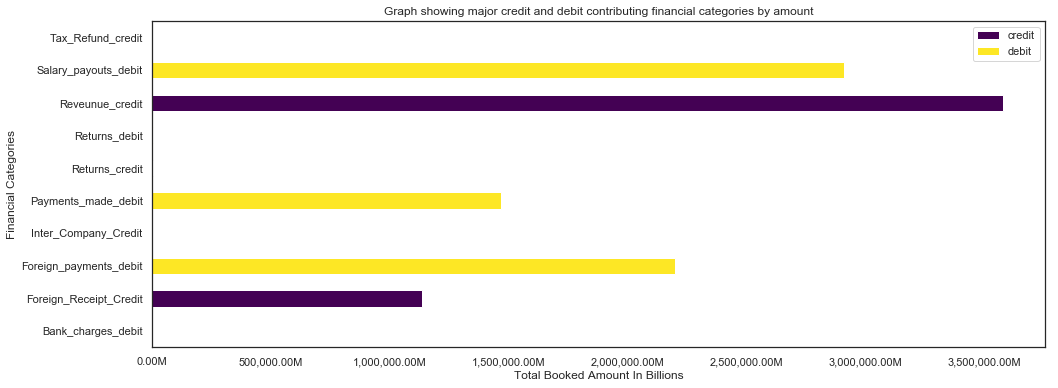

In [661]:
table = pd.pivot_table(df1, values=['credit', 'debit'], index=['financial_category'],
                     aggfunc={'credit': np.sum,
                              'debit': np.sum})

ax=table.plot(kind='barh', stacked=True, figsize=[16,6],colormap='viridis')
ax.set_title("Graph showing major credit and debit contributing financial categories by amount")
ax.set_xlabel("Total Booked Amount In Billions",fontsize=12)
ax.set_ylabel("Financial Categories",fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.show()

#The above pivot table has given us the following information:

1. Booking texts with most credits include : AUSSENH, GUTSCHRIFT,SEPA-Gutschrift and EUELEKTR or in terms of financial categories revenue credit and forgein credit receipts

2. Booking texts with the most debits include : AUSSENH, SEPA Basislastschrift,SEPA-Ueberweisung  and SEPA-Ueberweisungsdatei and in terms of financial categories - salary pay outs, Payments made and foreign payments made

**Note: we can scale down the x axis to see some more categories but we do not need that, we can see from the above chart that these categories and the subsided booking text within them will be able to give us a clear picture

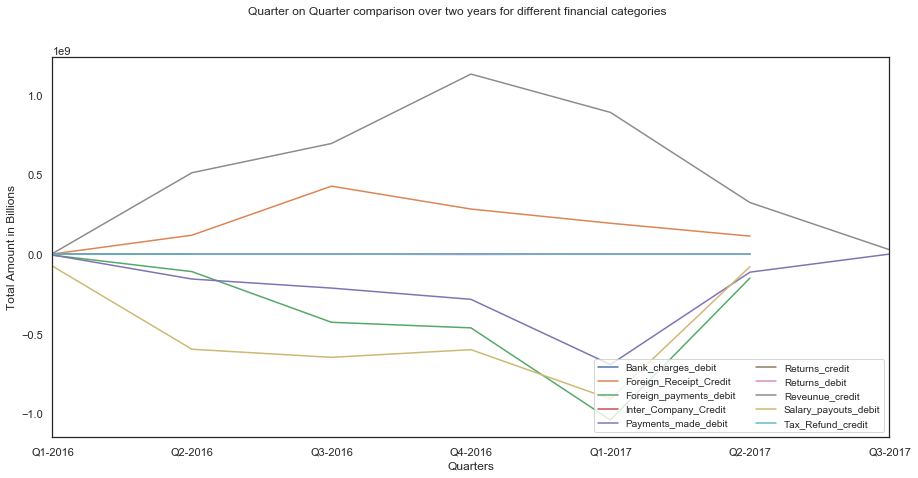

In [662]:
# plot total amount per quarter. 
#The following plot shows a clear comparison of one quarter of one year with the same quarter of another year
fig, ax = plt.subplots(figsize=(15,7))
df1.groupby(['Quarter','financial_category']).sum()['amount'].unstack().plot(ax=ax)
ax.legend(loc="lower right", fontsize='small', ncol=2)
fig.suptitle('Quarter on Quarter comparison over two years for different financial categories', fontsize=12)
plt.xlabel('Quarters', fontsize=12)
plt.ylabel('Total Amount in Billions', fontsize=12)
plt.show()

1. Huge amount of revenue credits have been recieved duirng Q4 2016
2. A huge debit can be seen in Q2017 in terms of foreign payments that have been made but that is not constant as it can be seen for other quarters
3. Salary pay out debits seem to be higher in 2016 as compared to 2017
4. Major foreign receipts of credits were recevied in Q1 2016 and Q4 2016
5. Tax refund credits and bank charges debits are minimilistic

**As we can there is a slump in the credit revenues that havebeen earned in 2016 which got slumped in 2017. This makes sense as the banks who will provide the credit line will see this trend as if the company has enough funds to fund the credit line in a timely manner which as of now doesnt seem to be a case. We will still see later if this is possible or not in question 3

### 2 :What amount of line would you give to XYZ GmbH in each month, assuming that we give each customer a credit line of 30% of its estimated total costs for the upcoming month.

### My assumptions for the computation of Question 2 and Question 3 are as follows:
    1. I have taken booking_date as the parameter to fetch transactions and booking text and financial categories that I have created to see the debit/credit happenings. from the data this field is more relevant as this looks like a company ledger where the data was stored when a booking was made. 
    2. For the month of February, as the data is starting from 22.02.2016 and the first booking was made in March 2016, we shall not be providing any credit line for the month of Feb 2016

**To answer to above question we need to first understand the following :

1. The net balance that has been drawn between the start balance date and end balance date
2. How much net amount is left in the same period which is a simple subtraction of credit-debit
3. Calculate the total costs for the current month and the upcoming month
4. The net value is left out on which we can provide the credit line of the 30% estimated total cost for the upcoming month

### Lets calculate the net balance month on month basis, I am assuming that net take forward balance that will be a subset of the end balance would credit-debit

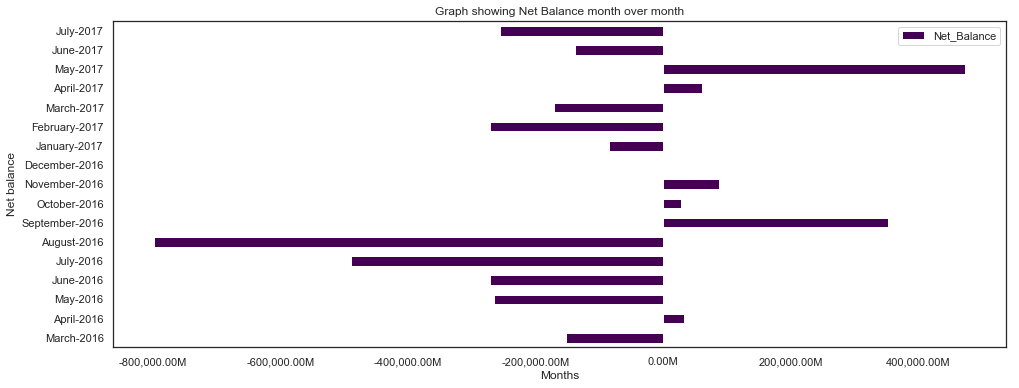

In [663]:
df1['Net_Balance'] = df1['credit'] - df1['debit']
table5 = pd.pivot_table(df1, values=['Net_Balance'], index=['month'],
                     aggfunc={'Net_Balance': np.sum})
ax=table5.plot(kind='barh', stacked=True, figsize=[16,6],colormap='viridis')
ax.set_title("Graph showing Net Balance month over month")
ax.set_xlabel("Months",fontsize=12)
ax.set_ylabel("Net balance",fontsize=12)
ax.set_yticklabels(('March-2016', 'April-2016', 'May-2016', 'June-2016', 'July-2016','August-2016','September-2016','October-2016',
                   'November-2016','December-2016','January-2017','February-2017','March-2017', 'April-2017', 'May-2017', 'June-2017', 'July-2017'))
plt.ticklabel_format(style='plain', axis='x')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.show()          

### Now as per the question, lets take all the costs that are there in the company that are required to be paid out on a monthly basis. These cost will serve to calculate the credit line on month on month basis

### I have taken the following costs that are bound to happen and will affect the XYZ GMBH cash flow every month:

SEPA-Ueberweisungsdatei
SEPA Basislastschrift
SEPA-Ueberweisung
AUSSENH.
EUELEKTR.
Kreditkartenabrechnung
Eilzahlung
SEPA-Aussenhandel
AUSZAHLUNG
STANDING ORDER
FUNDS TRANSFER DR
SEPA-Firmenlastschrift
SEPA manuelle Ueberweisung
AUSLSCHECK
Eilueberweisung
SEPA-Gutschrift
BELASTUNG

**The above booking texts have already been categorised under three major categories shown above in the code:

Salary_payouts_debit,
Payments_made_debit,
Foreign_payments_debit


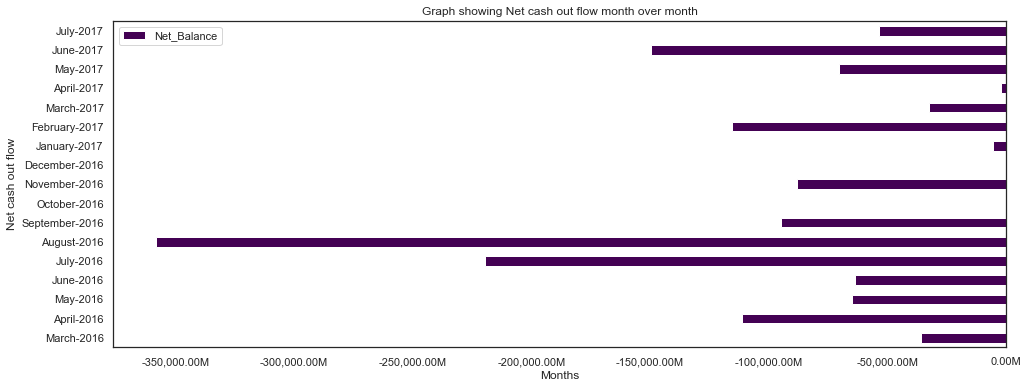

In [664]:
#Lets analyse the above costs on a month on month basis with a heat map to see the extreme values
table6 = pd.pivot_table(df1[df1.financial_category =='Payments_made_debit'], 
                        values=['Net_Balance'], index=['month'],
                         aggfunc={'Net_Balance': np.sum})
ax=table6.plot(kind='barh', stacked=True, figsize=[16,6],colormap='viridis')
ax.set_title("Graph showing Net cash out flow month over month")
ax.set_xlabel("Months",fontsize=12)
ax.set_ylabel("Net cash out flow",fontsize=12)
ax.set_yticklabels(('March-2016', 'April-2016', 'May-2016', 'June-2016', 'July-2016','August-2016','September-2016','October-2016',
                   'November-2016','December-2016','January-2017','February-2017','March-2017', 'April-2017', 'May-2017','June-2017','July-2017'))
plt.ticklabel_format(style='plain', axis='x')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.show()

The net balance for this category is negative month on month

The above representation shows us the movement of fixed cost of cash outflows from the organisation.
Now we are given the following two assumptions and one condition on which we will calculate the credit line

Assumptions:

    ● The credit line is calculated on the 1st of the month for the following month.
    ● The credit limit is based on the company's cash outflows (all outgoing transactions).
    
Condition:

    Each customer a credit line of 30% of its estimated total costs for the upcoming month.

#Credit Line calculation

In [665]:
# creating a new col to get the amount for all the payments that were made, this will make things easier to calc
# df1['Net_monthly_Cash_outflow'] = np.where(df1['financial_category'] == "Salary_payouts_debit,Payments_made_debit,Foreign_payments_debit", abs(df1.debit),0)
df1['Net_monthly_Cash_outflow']= np.where(df1['financial_category'].isin(['Salary_payouts_debit','Payments_made_debit','Foreign_payments_debit']), abs(df1.debit),0)
df1['credit_line'] = np.where(df1['Net_monthly_Cash_outflow']>0, abs(df1.Net_monthly_Cash_outflow).apply(lambda x: x*.3),0)

In [666]:
df1.head()

amount booking_date     booking_text date_end_balance date_start_balance  \
0  -60790   2017-06-30  SEPA-Gutschrift       2017-06-30         2017-06-01   
1     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
2     -10   2016-03-22        GEBUEHREN       2016-03-22         2016-02-22   
3     520   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   
4    4645   2016-03-21  SEPA-Gutschrift       2016-03-21         2016-03-15   

   end_balance       month  start_balance  tx_code  Quarter debit_credit  \
0     26931792   June-2017       26524408      166  Q2-2017        Debit   
1      3589838  March-2016        3590838      808  Q1-2016        Debit   
2        68788  March-2016          69788      808  Q1-2016        Debit   
3        46201  March-2016         452165      166  Q1-2016       Credit   
4        46201  March-2016         452165      166  Q1-2016       Credit   

   debit  credit   financial_category  Net_Balance  Net_monthly_Cash_outflow  \
0  60790       0  Payments_made_debit       -60790                     60790   
1     10       0   Bank_charges_debit          -10                         0   
2     10       0   Bank_charges_debit          -10                         0   
3      0     520      Reveunue_credit          520                         0   
4      0    4645      Reveunue_credit         4645                         0   

   credit_line  
0        18237  
1            0  
2            0  
3            0  
4            0

In [667]:
pd.options.display.float_format = '{:.0f}'.format

In [668]:
df1.groupby('month', as_index=False).agg({"credit_line": "sum"},format = '{:2f}')

month  credit_line
0       April-2016     52191293
1       April-2017     88733047
2      August-2016    109261889
3    December-2016    131180784
4    February-2017    247715170
5     January-2017    379139747
6        July-2016    170356153
7        July-2017            5
8        June-2016    142769585
9        June-2017        18237
10      March-2016     26403446
11      March-2017    166380091
12        May-2016     64160916
13        May-2017     14095193
14   November-2016    103281477
15    October-2016    169532697
16  September-2016    107157597

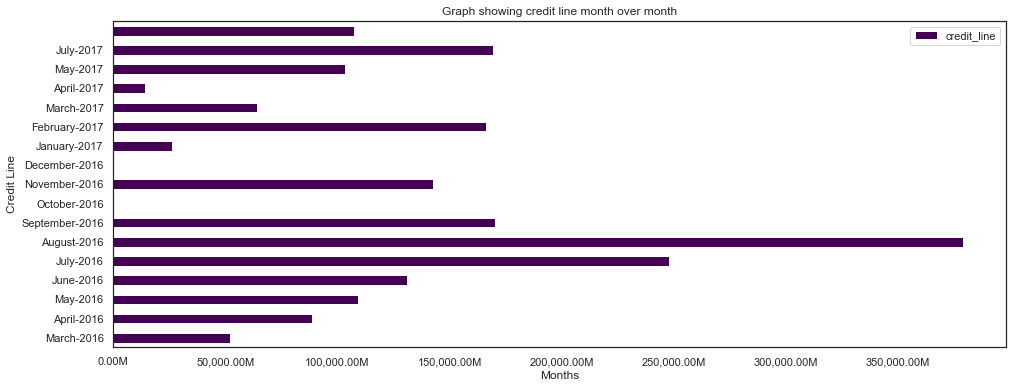

In [669]:
table7 = pd.pivot_table(df1, values=['credit_line'], index=['month'],
                     aggfunc={'credit_line': np.sum})
ax=table7.plot(kind='barh', stacked=True, figsize=[16,6],colormap='viridis')
ax.set_title("Graph showing credit line month over month")
ax.set_xlabel("Months",fontsize=12)
ax.set_ylabel("Credit Line",fontsize=12)
ax.set_yticklabels(('March-2016', 'April-2016', 'May-2016', 'June-2016', 'July-2016','August-2016','September-2016','October-2016',
                   'November-2016','December-2016','January-2017','February-2017','March-2017', 'April-2017', 'May-2017','July-2017'))
plt.ticklabel_format(style='plain', axis='x')
xlabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.show()

Lets see the correlation between the previous and the new variables that I have created

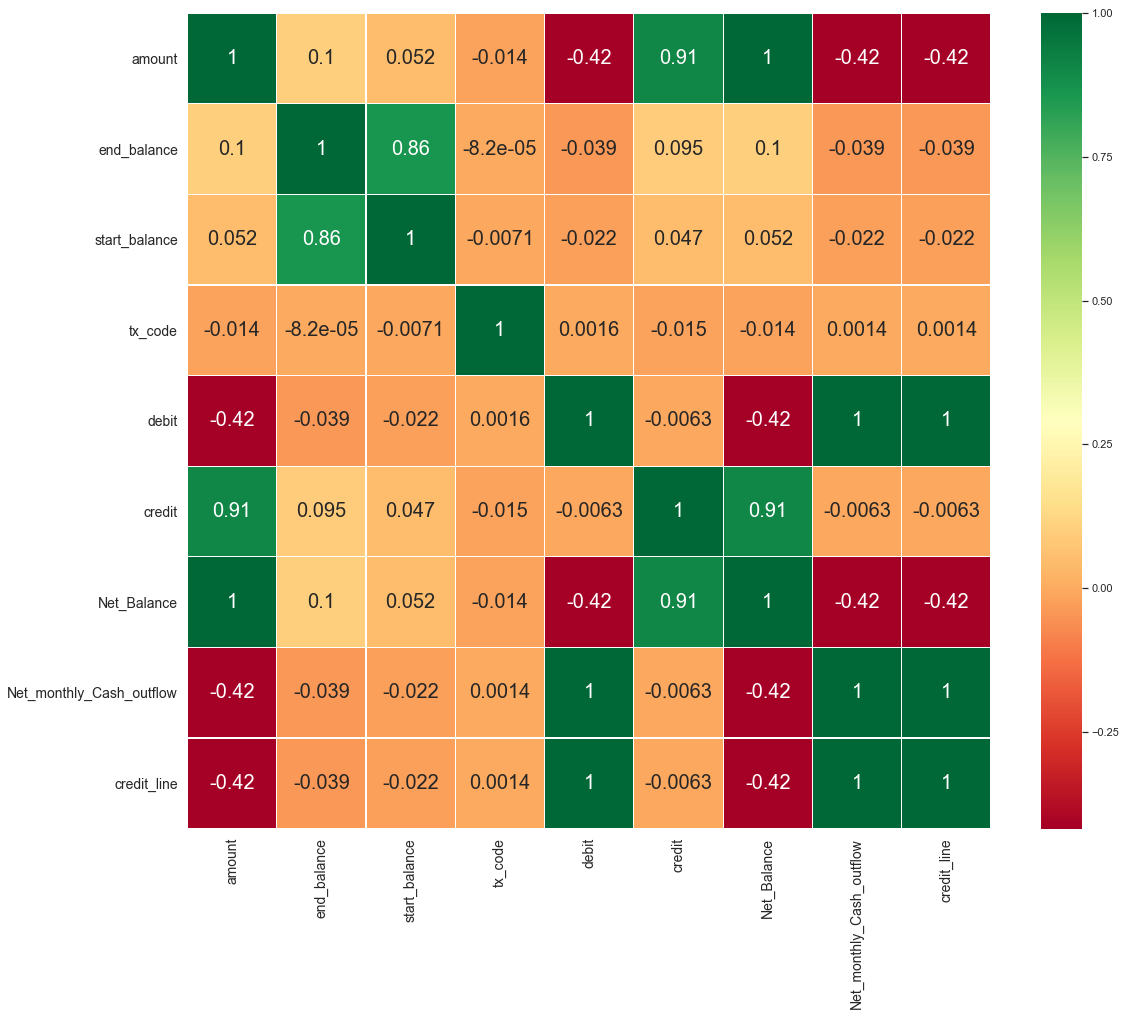

In [670]:
corr = df1.corr()
sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# 3. Given a monthly credit line of 30% of total cash outflow (we use the past months as a predictor for the following months; you can assume we calculate the line on the first of the month), determine

>a. In which months will company XYZ GmbH starts having problems to meet its debt obligations being too risky to continue having a monthly credit line.
>b. In which months will the company be able to meet its obligations normally again without a high risk.

>Before moving onto the last question, I would like to create a target variable called pd_default grouped at month level basis the following variables :

>Net Balacne bw start and end balance
>Credit line given
>Net_Balance
With the help of this col we will get a 0 or 1 for that particular month that what does the financial condition looks like for that month. this will help us in creating a prediction later on

> What we did till question 2 is to solve for credit line that is impacted by the total outflow of the cash and how much money would be required by the XYZ company to solve for there cash crunch if need be
> Now here, I will define as to how I will create a target variable as I cannot choose any random variable for my prediction of deliquent vs non delinquent months
> The formula that would work here looks like this : 
    >Closing balance of one month or Opening balance for other(Which shall be represented as  final balance) = Opening balance of prev month+Credit line + Net balance from start_balance and end_balance
    > for ex: Final_Feb_balance_2016 = start_balacnce of feb + Credit Line used in feb + net balance of feb 
> in the final step we also have to make sure to subtract the credit line that was received last month form this month that shows that credit line has been paid as well

In [671]:
#Lets create a new data set with only the variables that are required.
df2 = df1.groupby('month', as_index=False).agg({"Net_Balance": "sum","credit_line": "sum"}, format = '{:,.0f}')

In [672]:
df2.head(20)

month  Net_Balance  credit_line
0       April-2016   -151719081     52191293
1       April-2017     32070612     88733047
2      August-2016   -265222803    109261889
3    December-2016   -271377119    131180784
4    February-2017   -489940610    247715170
5     January-2017   -798291403    379139747
6        July-2016    352733582    170356153
7        July-2017     27466216            5
8        June-2016     87998270    142769585
9        June-2017       -60790        18237
10      March-2016    -84288408     26403446
11      March-2017   -271934540    166380091
12        May-2016   -170603960     64160916
13        May-2017     61352369     14095193
14   November-2016    473604096    103281477
15    October-2016   -138760512    169532697
16  September-2016   -255884855    107157597

>We are taking an assuption that no  credit line will be taken in the month of Feb 2016 as there are only two transactions happening there
>Also we will calculate the final balance for every month using the formula that we stated above
> No interst is to be paid for the previous month credit line and the standard paybakc time is one month, so its a recurrent month on month payment that needs to be made in order to get rid of the last months credit line   
   
   
>>Closing Balance of March 2016 = Opening Balance of March 2016 + Credit line received in March 2016 + Net Balance of March 2016 (after all the debit and credit offset) - Credit Line to be paid for Feb 2016


In [673]:
# unique_month = df2.month.unique()
# month_value = {}
# for month in unique_month:
#     month_value[month] = x_start_bal+df2.loc[df2['month'] == month, 'credit_line'].sum() + df2.loc[df2['month'] == month,'Net_Balance'].sum()
# for index, row in df2.iterrows():
#     if row['month'] in month_value:
#         df2['final_balance'] = month_value[row['month']]
#     else:
#         df2['final_balance'] = 0

In [674]:
x_start_bal = 452165 # opening balance of march
mar16_final_bal = x_start_bal+df2.loc[df2['month'] == 'March-2016', 'credit_line'].sum() + df2.loc[df2['month'] == 'March-2016', 'Net_Balance'].sum() 
apr16_final_bal = mar16_final_bal+df2.loc[df2['month'] == 'April-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'April-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'March-2016', 'credit_line'].sum()
may16_final_bal = apr16_final_bal+df2.loc[df2['month'] == 'May-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'May-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'April-2016', 'credit_line'].sum()
jun16_final_bal = may16_final_bal+df2.loc[df2['month'] == 'June-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'June-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'May-2016', 'credit_line'].sum()
jul16_final_bal = jun16_final_bal+df2.loc[df2['month'] == 'July-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'July-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'June-2016', 'credit_line'].sum()
aug16_final_bal = jul16_final_bal+df2.loc[df2['month'] == 'August-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'August-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'July-2016', 'credit_line'].sum()
sep16_final_bal = aug16_final_bal+df2.loc[df2['month'] == 'September-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'September-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'August-2016', 'credit_line'].sum()
oct16_final_bal = sep16_final_bal+df2.loc[df2['month'] == 'October-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'October-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'September-2016', 'credit_line'].sum()
nov16_final_bal = oct16_final_bal+df2.loc[df2['month'] == 'November-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'November-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'October-2016', 'credit_line'].sum()
dec16_final_bal = nov16_final_bal+df2.loc[df2['month'] == 'December-2016', 'credit_line'].sum()+df2.loc[df2['month'] == 'December-2016', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'November-2016', 'credit_line'].sum()
jan17_final_bal = dec16_final_bal+df2.loc[df2['month'] == 'January-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'January-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'December-2016', 'credit_line'].sum()
feb17_final_bal = jan17_final_bal+df2.loc[df2['month'] == 'February-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'February-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'January-2017', 'credit_line'].sum()
mar17_final_bal = feb17_final_bal+df2.loc[df2['month'] == 'March-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'March-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'February-2017', 'credit_line'].sum()
apr17_final_bal = mar17_final_bal+df2.loc[df2['month'] == 'April-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'April-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'March-2017', 'credit_line'].sum()
may17_final_bal = apr17_final_bal+df2.loc[df2['month'] == 'May-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'May-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'April-2017', 'credit_line'].sum()
jun17_final_bal = apr17_final_bal+df2.loc[df2['month'] == 'June-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'June-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'May-2017', 'credit_line'].sum()
jul17_final_bal = jun17_final_bal+df2.loc[df2['month'] == 'July-2017', 'credit_line'].sum()+df2.loc[df2['month'] == 'July-2017', 'Net_Balance'].sum()-df2.loc[df2['month'] == 'June-2017', 'credit_line'].sum()

In [675]:
cond=[(df2['month'] == month) for month in df2['month'].unique()]
values= [mar16_final_bal ,apr16_final_bal ,may16_final_bal ,jun16_final_bal ,jul16_final_bal ,aug16_final_bal ,sep16_final_bal ,oct16_final_bal ,nov16_final_bal ,dec16_final_bal,
         jan17_final_bal ,feb17_final_bal ,mar17_final_bal ,apr17_final_bal ,may17_final_bal ,jun17_final_bal,jul17_final_bal]
df2['final_balance'] = np.select(cond,values)

In [676]:
df2.head(20)

month  Net_Balance  credit_line  final_balance
0       April-2016   -151719081     52191293      -57432797
1       April-2017     32070612     88733047     -183364031
2      August-2016   -265222803    109261889     -341998368
3    December-2016   -271377119    131180784     -175391429
4    February-2017   -489940610    247715170      204928721
5     January-2017   -798291403    379139747     -121388346
6        July-2016    352733582    170356153     -379377493
7        July-2017     27466216            5     -455762905
8        June-2016     87998270    142769585      -48410029
9        June-2017       -60790        18237     -291887841
10      March-2016    -84288408     26403446     -842220281
11      March-2017   -271934540    166380091    -1463585468
12        May-2016   -170603960     64160916    -1816855087
13        May-2017     61352369     14095193    -1862431519
14   November-2016    473604096    103281477    -1875717005
15    October-2016   -138760512    169532697    -1876569265
16  September-2016   -255884855    107157597    -1849121281

>I will create now a new variable pd_default basis the following:
    The Credit line is provided and still the final balance is negative then pd_default = 0 -company has negative cash flow so credit line cant be paid
    The Credit line is provided and still the final balance is positive then pd_default = 1 -company has positive cash flow so credit line cant be paid

In [677]:
df2['prob_default'] = np.where(df2['final_balance']>1 ,1,0)
df2.head()

month  Net_Balance  credit_line  final_balance  prob_default
0     April-2016   -151719081     52191293      -57432797             0
1     April-2017     32070612     88733047     -183364031             0
2    August-2016   -265222803    109261889     -341998368             0
3  December-2016   -271377119    131180784     -175391429             0
4  February-2017   -489940610    247715170      204928721             1

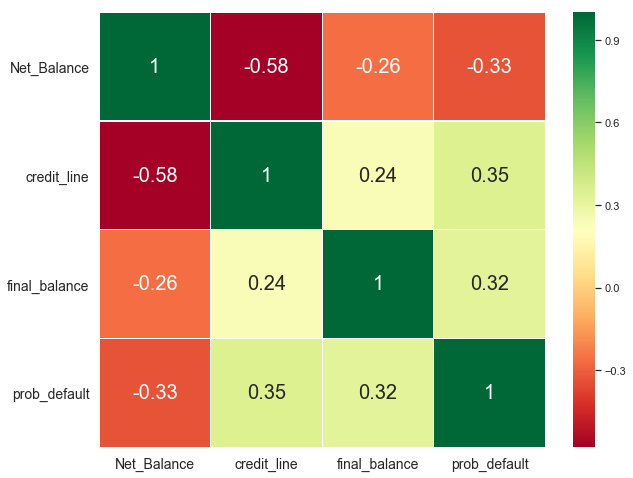

In [678]:
corr = df2.corr()
sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [619]:
# # import labelencoder
# from sklearn.preprocessing import LabelEncoder
# # instantiate labelencoder object
# le = LabelEncoder()

In [627]:
# # apply le on categorical feature columns
# df2[categorical_cols] = df2[categorical_cols].apply(lambda col: le.fit_transform(col))
# df2[categorical_cols].head(20)

In [679]:
# convert rest of categorical variable into dummy
df2 = pd.get_dummies(df2, drop_first=True)

In [680]:
df2.shape

(17, 20)

In [681]:
df2.head()

Net_Balance  credit_line  final_balance  prob_default  month_April-2017  \
0   -151719081     52191293      -57432797             0                 0   
1     32070612     88733047     -183364031             0                 1   
2   -265222803    109261889     -341998368             0                 0   
3   -271377119    131180784     -175391429             0                 0   
4   -489940610    247715170      204928721             1                 0   

   month_August-2016  month_December-2016  month_February-2017  \
0                  0                    0                    0   
1                  0                    0                    0   
2                  1                    0                    0   
3                  0                    1                    0   
4                  0                    0                    1   

   month_January-2017  month_July-2016  month_July-2017  month_June-2016  \
0                   0                0                0                0   
1                   0                0                0                0   
2                   0                0                0                0   
3                   0                0                0                0   
4                   0                0                0                0   

   month_June-2017  month_March-2016  month_March-2017  month_May-2016  \
0                0                 0                 0               0   
1                0                 0                 0               0   
2                0                 0                 0               0   
3                0                 0                 0               0   
4                0                 0                 0               0   

   month_May-2017  month_November-2016  month_October-2016  \
0               0                    0                   0   
1               0                    0                   0   
2               0                    0                   0   
3               0                    0                   0   
4               0                    0                   0   

   month_September-2016  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [682]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,precision_recall_curve
from sklearn.model_selection import train_test_split

In [684]:
#Definfing X and Y
X=df2.drop('prob_default', axis=1)
y= df2['prob_default']
#scaling the variables
robust_scaler = RobustScaler()
X=robust_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,shuffle=True)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (12, 19)
Number transactions y_train dataset:  (12,)
Number transactions X_test dataset:  (5, 19)
Number transactions y_test dataset:  (5,)


In [685]:
def CMatrix(CM, labels = ['final_balance','prob_default']):
    df2=pd.DataFrame(data=CM, index=labels,columns=labels)
    df2.index.name = 'True'
    df2.columns.name='Prediction'
    df2.loc['Total'] = df2.sum()
    df2['Total']=df2.sum(axis=1)
    return df2    

In [686]:
metrics = pd.DataFrame(index = ['accuracy','precision','recall'],
                      columns=['LogisticRegression','ClassTree','NaiveBayes'])

B. we try Logistic regression model

In [687]:
import warnings
warnings.filterwarnings('always')
# 1 . import the model or the estimator first
from sklearn.linear_model import LogisticRegression
# creating an instance of the model or the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
#use the training data to train the estimator
logistic_regression.fit(X_train,y_train)
#Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticRegression'] = accuracy_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['precision','LogisticRegression'] = precision_score(y_pred=y_pred_test,y_true=y_test)
metrics.loc['recall','LogisticRegression'] = recall_score(y_pred=y_pred_test,y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test,y_true=y_test)
CMatrix(CM)

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



Prediction     final_balance  prob_default  Total
True                                             
final_balance              4             1      5
prob_default               0             0      0
Total                      4             1      5

In [688]:
from sklearn.metrics import confusion_matrix, accuracy_score ,f1_score,classification_report
model_name = type(model).__name__
print(model_name)
print(confusion_matrix(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(accuracy_score(y_pred_test, y_test))

Pipeline
[[4 0]
 [1 0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

   micro avg       0.80      0.80      0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

0.8


C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [689]:
logistic_regression.fit(X, y)

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=15, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [690]:
precision_lr, recall_lr,thresholds_lr = precision_recall_curve(y_true=y_test,
                                                              probas_pred=logistic_regression.predict(X_test))

C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:526: RuntimeWarning:

invalid value encountered in true_divide



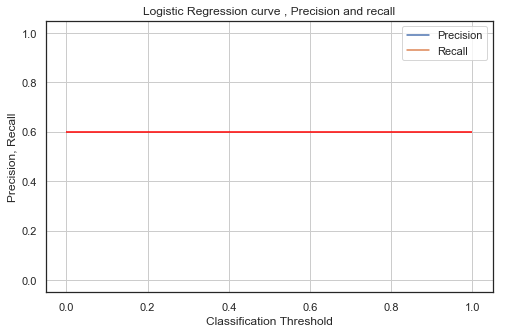

In [695]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label = 'Precision')
ax.plot(thresholds_lr, recall_lr[1:], label = 'Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression curve , Precision and recall')
ax.hlines(y=0.6,xmin = 0,xmax=1,colors='red')
ax.legend()
ax.grid()

the results that we have got above are when the classigication level is 0.6 and now we need to adjust the same to understand the risk 

Changing the classification threshold

In [698]:
y_pred_prob = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test =(y_pred_prob >= 0.2).astype('int')
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall:", 100*recall_score(y_pred=y_pred_test,y_true=y_test))
print("Precision:", 100*precision_score(y_pred=y_pred_test,y_true=y_test))
CMatrix(CM)

Recall: 0.0
Precision: 0.0


C:\Users\Ishan.Babbar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.



Prediction     final_balance  prob_default  Total
True                                             
final_balance              4             1      5
prob_default               0             0      0
Total                      4             1      5

Post this step I want to Make individual prediction but I cant do it as I have missed recall and precision and I am not sure why

In [ ]:
# # filename = 'new_trained_model_BS.pkl'
# filename = 'new_trained_model_PL.pkl'
# from sklearn.externals import joblib
# import pickle
# pickle.dump(model, open(filename, 'wb'))

# # remove comments below to test out the model
# model = joblib.load('new_trained_model_PL.pkl')
# question = input('Kontoname:')
# model.predict([question])[0]